Project: Titan Lightcurve - Polarization-phase curve

Author: Alex Medina

Organization: University of Central Florida

In [14]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#Most important import, in order to read and manipulate image in .IMG or VICAR format
#The python package is called "rms-vicar"
import vicar
#The second most important package to use is called "opencv"
#Used to manipulate general images
#Not used in the brightness phase curves but to keep it consistent with the polarization phase curves
import cv2

Polarized images are created using the make_polar_virtual_machine.sav IDLVM script; with polarization being calculated by taking ratios in the iamges using different polarizers. However, this process has no knowledge of which pixels are on Titan and which pixels are not, so the entire image has polarization values. The values away from Titan are a combination of light spread beyond the limb from the point spread function, and noise in the CCD and possibly also some stray light if the camera is pointing close to Saturn or the Sun. So, to interpret the polarization image I needed to restrict my analysis to the disk of Titan, including pixels beyond the terminator since Titan’s extended atmosphere is lit by the sun over a large region beyond the geometric terminator. For the same reason, values in the theta image(for angle of linear polarization) should be ignored if they are not on the target.

For the $\frac{I}{F}$ images this was not critical since the intensity drops to near zero sufficiently far from the target, and you want to include intensity beyond the limb. To only consider pixels within the disk of Titan in the image, I used the python package, opencv. First, I create a copy of the image, to not mess with original strucure of the .IMG of .VIC images, and detect the disk or circle of Titan; after it is detected, the output is a pair of coordinates for the center of the disk. To define an effective radius for the disk of Titan, I just plot the total brightness of a circle centered on Titan for incresing radius and plot it: when the plot begins to plateau, pixels beyond this plateau are no relevant.

In [15]:
def image_center(image):
    #Creating a copy of the image to avoid messing with the original

    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #Detect circle; I leave these parameters as is but they can be adjust to make circle detection more or less negative
    #I found that this is the best combination of parameters
    detected_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=30, maxRadius=500)

    #If a circle is detected this will draw a circle and return center coordinates (x, y) with a radius a
    #But the radius is too rough, we determine it more accurately later, and we actually dont need to draw the circle
    if detected_circles is not None:
        detected_circles = np.round(detected_circles[0, :]).astype("int")
        for (x, y, r) in detected_circles:
            #Draw a cirlce of radius 1 around center to show center
            #cv2.circle(image_copy, (x, y), r, (0, 255, 0), 2)
            #Draw a circle of radius r around center to show radius
            #cv2.circle(image_copy, (x, y), 1, (0, 0, 255), 3)
            #Show the image
            #cv2.imshow(image_copy)
            #print({x}, {y})
            return (x, y)
    #Debug
    else:
        print("No circle found")
        return None

#To determine the effective radius, as mentioned, I plot the brightness against increasing radius
def radii_fluxes_from_image(image, center):
    x, y = center
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    #Each image is mach 1024 pixels wide, so set the maximum to 1000 to be safe
    radii = range(1, 1000, 5)
    flux = []

    for r in radii:
        mask = np.zeros_like(gray_image)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

        #Applying mask to the image
        #Masking is one of the most important features that I take advantage of with opencv
        #This makes it so the circle of Titan is the ONLY part of the image that is showing and the rest is turned to either 0 or 1
        masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
        flux.append(np.sum(masked))
    return radii, flux

#Manual inspection and testing
def radii_fluxes_plot(radii, flux):
    plt.plot(radii, flux)
    plt.xlabel("Radius")
    plt.ylabel("Flux")
    plt.title("Flux vs. Radius")
    plt.show()

#To determine the effective radius, I originally used a gradient
#When the slope approaches 0, then that is a good point
#It works because Titan is really close to the Earth and the images have a lot of pixels
#But, in general, we don't have the luxury of so many pixels so just getting in the practice that this plateau point is determined when the difference between the current and previous pixel is...
#...much much less than the previous pixel
def effective_radius(radii, flux):
    for i in range(1, len(flux)):
        if flux[i] - flux[i-1] < 0.01 * flux[i-1]:
            return radii[i]
    #If no plateau is detected can return last radius
    #return radii[-1]

    #Debugging
    print("No plateau found")
    return None

Unlike brightness images where pixel units are in $\frac{I}{F}$, degree of linear polarization is unitless. To go from the intensity, polarization, and theta images to disk-integrated Q/I or polarization, I do a proper sum which takes into account how much each pixel contributes to the total. To give a little bit of background and starting with small assumptions; using Stokes vector, we define the degree of linear polarization(no circular polarization) as:

\begin{equation}
P = \frac{\sqrt{Q^2 + U^2}}{I}.
\end{equation}

Since each pixel has a calculated version of P, Q, and U, a more accurate representation is per pixel:

\begin{equation}
P_i = \frac{\sqrt{(Q_i)^2 + (U_i)^2}}{I_i}.
\end{equation}

So we can find the total degree of linear polarization by summing all pixels on Titan. In a simplified case, let's assume that there is no U, and there is only a Q component, when we can say:

\begin{equation}
P_i = \frac{Q_i}{I_i}.
\end{equation}

Which can be reworked as a weighted sum for total linear polarization or $\frac{Q}{I}$ as:

\begin{equation}
\frac{Q}{I} = P = \frac{\sum_{j} \frac{I_j}{F} P_j}{\sum_{j }\frac{I_j}{F}}.
\end{equation}

One last thing to note is there there are two ways to go about this, doing just the disk of Titan or the whole image. Since we are doing a weighted sum and pixels off of the disk of Titan in the IF image fall to zero, the poalrization values off of the disk Titan won't contribute much at all, so we can jsut sum over entire image - although I put it both ways to be safe and test and after testing, less thant 1% error.

In [16]:
def simple_dlop(pol_image, IF_image, center, radius):
    #pol short for polarization images
    mask_pol = np.zeros_like(pol_image)
    #Fills the circle with 1s and the outside is 0
    #So that when we sum, we multiply the image by the mask, and the 0 multiplication gets rid of eveything outside of the disk
    #And everything inside the disk is summed but stays the same because multiplied by 1
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    #ins short for I/F images
    mask_IF = np.zeros_like(IF_image)
    cv2.circle(mask_IF, center, radius, 1, thickness=-1)
    IF_masked = IF_image * mask_IF

    #weighted = np.sum(IF_masked * pol_masked)
    #total_IF = np.sum(IF_masked)

    weighted = np.sum(IF_image * pol_image)
    total_IF = np.sum(IF_image)


    return weighted / total_IF

Here, we input the path where the calibrated AND poalrized images are located. Of course, this is unique to my setup and the data that I have.

In [17]:
pol_images = r'C:\Users\Alex\Desktop\Titan\Polarized Images\GRN_P\GRN_POL'

#Have the same path
IF_images = r'C:\Users\Alex\Desktop\Titan\Polarized Images\GRN_P\GRN_POL'

pol_IF_metadata = r'C:\Users\Alex\Desktop\Titan\Polarized Images\GRN_P\GRN_POL\pol_data.csv'
#Reading the csv file
parameters_df = pd.read_csv(pol_IF_metadata)

Because we have to sort through different files in the same folder, it gets kinda messy, but here is a way to make it work: I can group the center and effectiv radius (x, y, r) and create a dictionary, in the folder there are three .VIC that correspond to the same image, hence they have the same beginning but different ending, i.e NXXXXXX_pol.vic and NXXXXXXX_I_over_F.vic, so we can match the corrdinates from the I_over_F coordinates to the _pol.vic images.

In [18]:
#Grouping the circle center and radius for our dictionary
def find_circle_params(image_path):
    vic = vicar.VicarImage(image_path, strict=False)
    image = vic.data_2d
    center = image_center(image)
    radii, fluxes = radii_fluxes_from_image(image, center)
    eff_radius = effective_radius(radii, fluxes)
    return center, eff_radius

#Creating a dictionary with the opus_id being used as the key since it matches the polarized images and IF images
#And the corresponding center coordinates and effective radius are stored as the value

circle_params = {}
for filename in os.listdir(IF_images):
    if filename.endswith('_I_over_F.vic'):
        coordinate_image_path = os.path.join(IF_images, filename)
        opus_id = filename.split('_')[0]
        try:
            center, eff_radius = find_circle_params(coordinate_image_path)
            circle_params[opus_id] = (center, eff_radius)
            print(f'{filename}: {center}, {eff_radius}')
        #Debug
        except Exception as e:
            print(f"{filename}: {e}")

N1486913_I_over_F.vic: (np.int64(253), np.int64(263)), 181
N1494007_I_over_F.vic: (np.int64(447), np.int64(340)), 361
N1499415_I_over_F.vic: (np.int64(523), np.int64(523)), 371
N1515805_I_over_F.vic: (np.int64(517), np.int64(517)), 376
N1521214_I_over_F.vic: (np.int64(532), np.int64(527)), 391
N1526619_I_over_F.vic: (np.int64(478), np.int64(521)), 406
N1530756_I_over_F.vic: (np.int64(531), np.int64(506)), 361
N1534852_I_over_F.vic: (np.int64(490), np.int64(513)), 376
N1536147_I_over_F.vic: (np.int64(506), np.int64(511)), 401
N1537508_I_over_F.vic: (np.int64(512), np.int64(523)), 381
N1547135_I_over_F.vic: (np.int64(527), np.int64(514)), 401
N1549547_I_over_F.vic: (np.int64(512), np.int64(496)), 411
N1551056_I_over_F.vic: (np.int64(482), np.int64(495)), 381
N1553821_I_over_F.vic: (np.int64(518), np.int64(532)), 336
N1556523_I_over_F.vic: (np.int64(501), np.int64(551)), 391
N1557905_I_over_F.vic: (np.int64(484), np.int64(571)), 376
N1559282_I_over_F.vic: (np.int64(494), np.int64(560)), 3

Finally, we have a center and effective radius in order to mask the polarized image and calculate the total degree of linear polarization, or a simplified case of $\frac{Q}{I}$, and we already know the phase angle from the metadata. So this follows the exact same process as that of the brightness-phase curves, jsut with different naming conventions and a center and effective radius line.

In [19]:
#List lists for results
simple_dlops = []
phase_angles = []

#Because the .IMG calibrated images don't match 1:1 with the metadata, we have to do some fun things
#Same loop as before but additional if for center coords and radius
for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
    #if filename.endswith('_Theta.vic'):
    #if filename.endswith('_Q.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        #Since these images are in .IMG(or .VIC) format, simple line to read image from rms-vicar package
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        #The coordinate images are also the _I_over_F.vic images just with that different ending
        #Removing that ending they have the exact same naming structure
        #Trying a replace, this works because _Pol.vic and _I_over_F.vic are both in the "polarized images" folder
        #I just named them differently for convenience
        IF_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        IF_vic = vicar.VicarImage(IF_image_path, strict=False)
        read_IF_image = IF_vic.data_2d


        opus_id = filename.split('_')[0]
        #Comparatively, in the brightness-phase curve we used metadata file from OPUS, but here i created my own
        #So no need to add the prefix 'co-iss-' or change from upper to lowercase
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        #opus_id in circle_params becasue both I_over_F and pol images have same naming convention before the understore defined in circle params
        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Assocating the meta data with the image, pixel_scale and phase_angle
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]

                s_dlop = simple_dlop(read_pol_image, read_IF_image, center, eff_radius)

                #Creating array to plot
                phase_angles.append(phase_angle)
                simple_dlops.append(s_dlop)

                #For manual inspection
                print(f'{filename}: {s_dlop}')

N1486913_Pol.vic: 0.05082380399107933
N1494007_Pol.vic: 0.20854857563972473
N1499415_Pol.vic: 0.2674269378185272
N1515805_Pol.vic: 0.13605856895446777
N1521214_Pol.vic: 0.3338969945907593
N1526619_Pol.vic: 0.4484656751155853
N1530756_Pol.vic: 0.3292287588119507
N1534852_Pol.vic: 0.3200559616088867
N1536147_Pol.vic: 0.27001720666885376
N1537508_Pol.vic: 0.312184602022171
N1547135_Pol.vic: 0.3618309497833252
N1549547_Pol.vic: 0.3874169886112213
N1551056_Pol.vic: 0.30346181988716125
N1553821_Pol.vic: 0.18059566617012024
N1556523_Pol.vic: 0.0916365534067154
N1557905_Pol.vic: 0.059100933372974396
N1559282_Pol.vic: 0.04423971101641655
N1567440_Pol.vic: 0.04744228720664978
N1570185_Pol.vic: 0.06467089056968689
N1571476_Pol.vic: 0.41163384914398193
N1577094_Pol.vic: 0.14877177774906158
N1579533_Pol.vic: 0.26108941435813904
N1582634_Pol.vic: 0.25776398181915283
N1585391_Pol.vic: 0.3269842565059662
N1617163_Pol.vic: 0.43054622411727905
N1617165_Pol.vic: 0.44389957189559937


Now, we have all the important information, an image (or data point) with a degree of a simplified $\frac{Q}{I}$ (y) and a phase angle(x).

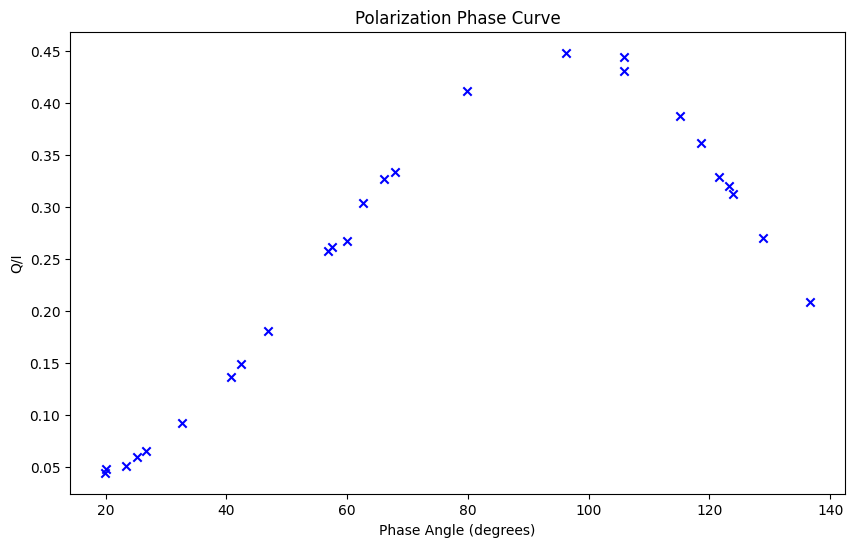

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_dlops, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q/I')
plt.title('Polarization Phase Curve')
plt.show()

Having examined outliers(explained in procedure), as a final step for consistency, I use the preliminary plot to gauge an idea for the maximum value. Hence, with this last section, I manually adjust the y axis height and tick number(at least divisible by 5). X-axis remains consistant across all filters.

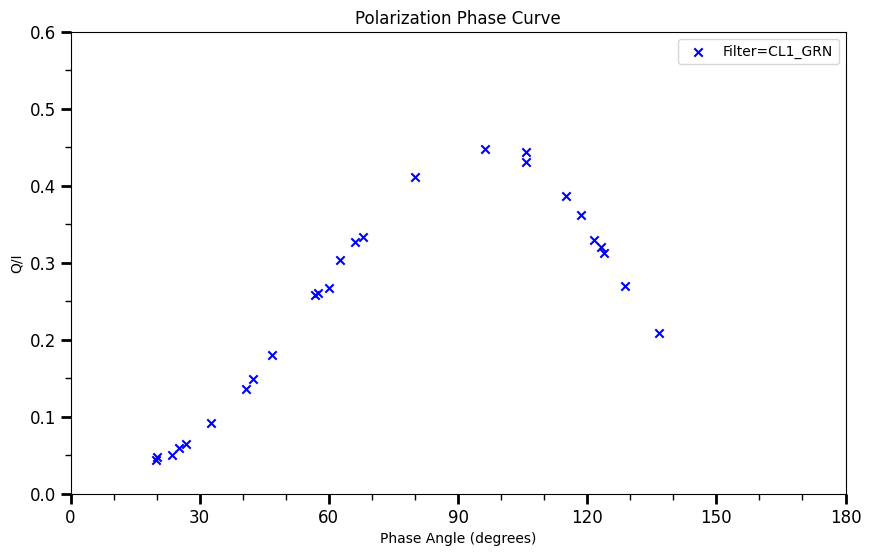

In [21]:
#Fancy plot for consistency across all plots but also visually will look better
filtername = 'CL1_GRN'

#Same as before
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_dlops, color='b', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q/I')
plt.title('Polarization Phase Curve')

#x-ticks(phase angle) at every 10 ticks but a more pronounced tick at every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)
ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent
ay = plt.gca()
#Thicker ticks every 5
ay.set_yticks([i * 0.1 for i in range(7)], minor=False)
ay.set_yticks([i * 0.05 for i in range(60)], minor=True) 
plt.ylim(0, 0.60)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()

W originally had:

\begin{equation}
\frac{Q}{I} = P = \frac{\sum_{j} \frac{I_j}{F} P_j}{\sum_{j }\frac{I_j}{F}}.
\end{equation}

Where a term

\begin{equation}
\frac {\mathcal{S^2}_{\text{pixel}}} {\pi R_{\text{target}}}
\end{equation}

Was canceled out. Hence, for Q by itself, we essentially do the reflectivity equation weighted by the polarization

\begin{equation}
Q = \frac{ \sum_{j} \frac{I_j P_j}{F} \mathcal{S^2}_{\text{pixel}}} {\pi {R^2}_{\text{target}}}
\end{equation}

In [22]:
def simple_stokes_Q(pol_image, IF_image, center, radius, pixel_scale):

    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_IF = np.zeros_like(IF_image)
    cv2.circle(mask_IF, center, radius, 1, thickness=-1)
    IF_masked = IF_image * mask_IF

    #weighted = np.sum(IF_masked * pol_masked)
    weighted = np.sum(IF_image * pol_image)

    R = 2575 #km

    return (weighted * pixel_scale**2) / (np.pi * R**2)

In [23]:
#We use the exact same files and images so nothing from the loop has to change other than the y variable which wil just calculate Q this time

simple_Q = []


for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        IF_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        IF_vic = vicar.VicarImage(IF_image_path, strict=False)
        read_IF_image = IF_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

                s_q = simple_stokes_Q(read_pol_image, read_IF_image, center, eff_radius, pixel_scale)

                #Creating array to plot
                simple_Q.append(s_q)

                #For manual inspection
                print(f'{filename}: {s_q}')

N1486913_Pol.vic: 0.010298962007531606
N1494007_Pol.vic: 0.016345829408237804
N1499415_Pol.vic: 0.03620031165291024
N1515805_Pol.vic: 0.02301404507328707
N1521214_Pol.vic: 0.03846189882853964
N1526619_Pol.vic: 0.03631153516448618
N1530756_Pol.vic: 0.023741178735546292
N1534852_Pol.vic: 0.02201044916189761
N1536147_Pol.vic: 0.019048796228386462
N1537508_Pol.vic: 0.02169462408323795
N1547135_Pol.vic: 0.0238911304710561
N1549547_Pol.vic: 0.025499186341981277
N1551056_Pol.vic: 0.03549510922526907
N1553821_Pol.vic: 0.026930112392160484
N1556523_Pol.vic: 0.01657141751639797
N1557905_Pol.vic: 0.011579398705822863
N1559282_Pol.vic: 0.009135613549300346
N1567440_Pol.vic: 0.009874401996303678
N1570185_Pol.vic: 0.012590661602277627
N1571476_Pol.vic: 0.039748898581614775
N1577094_Pol.vic: 0.023951065239886427
N1579533_Pol.vic: 0.03396286597688654
N1582634_Pol.vic: 0.03395752578074633
N1585391_Pol.vic: 0.03756746678771408
N1617163_Pol.vic: 0.029821139449103626
N1617165_Pol.vic: 0.030425582113816872

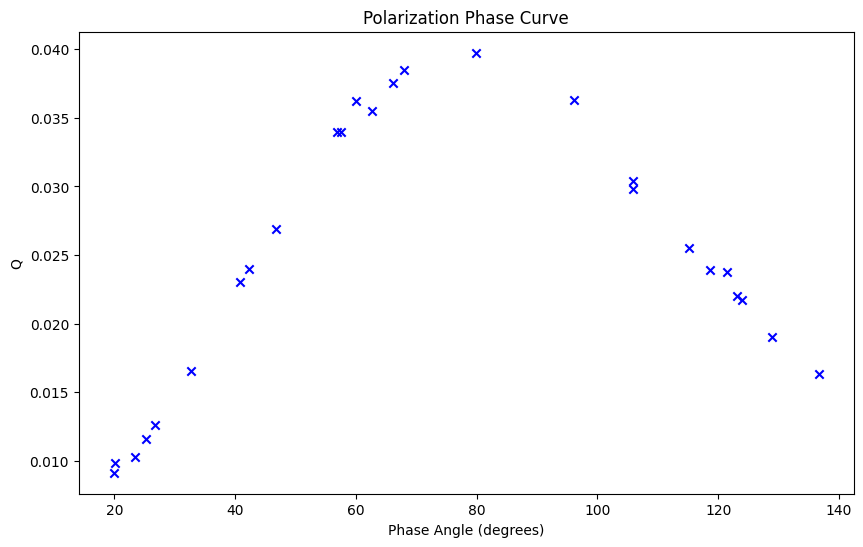

In [24]:
#And we plot again

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_Q, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')
plt.show()

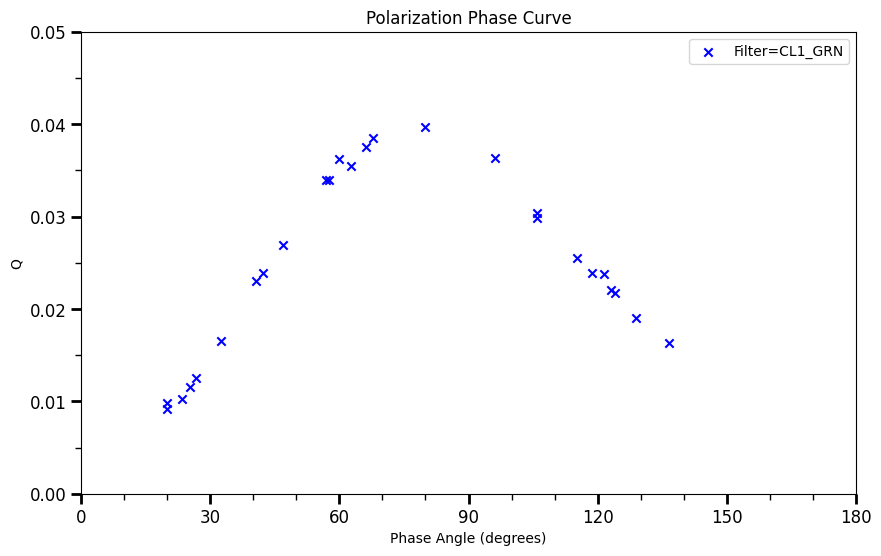

In [25]:
#Fancy plot for consistency across all plots but also visually will look better
filtername = 'CL1_GRN'

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_Q, color='b', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')

#x-ticks(phase angle) at every 10 ticks but a more pronounced tick at every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)
ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent
ay = plt.gca()
#Thicker ticks every 5
ay.set_yticks([i * 0.01 for i in range(6)], minor=False)
ay.set_yticks([i * 0.005 for i in range(50)], minor=True) 
plt.ylim(0, 0.05)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()

As a next step; ABOVE, we considered the case where U = 0, such that P = Q/I, but if there is both Q and U, we can determine and plot those individually. After quickly reading through the literature, it can be assumed that U is 0 but, lets take it such that it is not 0, and what we would do in that case. By definition, the degree of linear poalrization is:

\begin{equation}
P = \frac{\sqrt{Q^2 + U^2}}{I}.
\end{equation}

The stokes parameters have the form:

\begin{equation}
Q = IPcos(2\theta)
\end{equation}

\begin{equation}
U = IPsin(2\theta)
\end{equation}

Where, we calcualte Q and U per pixel and add up each pixel to get a value for the disk, and can be normalized in the same way as the previous Q and reflectivity equations

\begin{equation}
Q = \frac{ \sum_{i} \frac{I_i}{F} P_i cos(2\theta_{i}) S_{pixel}^2 } {\pi R_{Titan}^2}
\end{equation}

In [59]:
def norm_stokes_Q(pol_image, IF_image, thet_image, center, radius, pixel_scale):
    
    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_IF = np.zeros_like(IF_image)
    cv2.circle(mask_IF, center, radius, 1, thickness=-1)
    IF_masked = IF_image * mask_IF

    mask_thet = np.zeros_like(thet_image)
    cv2.circle(mask_thet, center, radius, 1, thickness=-1)
    thet_masked = thet_image * mask_thet

    #weighted = np.sum(IF_masked * pol_masked * np.cos(2*thet_masked))
    
    thet_rad = np.deg2rad(thet_image)

    weighted = np.sum(IF_image * pol_image * np.cos(2*thet_rad))

    R = 2575 #km

    return (weighted * pixel_scale**2) / (np.pi * R**2)
    #We are inevitibly getting really small values because we are integrating over Titan's disk area
    #Attempt to ingrate of the disk then normalize post=hoc for plotting
    #return weighted / np.sum(IF_masked)


def norm_stokes_U(pol_image, IF_image, thet_image, center, radius, pixel_scale):
    
    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_IF = np.zeros_like(IF_image)
    cv2.circle(mask_IF, center, radius, 1, thickness=-1)
    IF_masked = IF_image * mask_IF

    mask_thet = np.zeros_like(thet_image)
    cv2.circle(mask_thet, center, radius, 1, thickness=-1)
    thet_masked = thet_image * mask_thet

    #weighted = np.sum(IF_masked * pol_masked * np.sin(2*thet_masked))
    thet_rad = np.deg2rad(thet_image)

    weighted = np.sum(IF_image * pol_image * np.sin(2*thet_rad))

    R = 2575 #km

    return (weighted * pixel_scale**2) / (np.pi * R**2)
    #return weighted / np.sum(IF_masked)

And we run the same look as a visual test because again, we use the same images, just changing the y axis and adding a theta section.

In [60]:
#We use the exact same files and images so nothing from the loop has to change other than the y variable which wil just calculate Q this time

norm_Q = []
norm_U = []


for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        IF_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        IF_vic = vicar.VicarImage(IF_image_path, strict=False)
        read_IF_image = IF_vic.data_2d

        thet_image_path = pol_image_path.replace('_Pol.vic', '_Theta.vic')
        thet_vic = vicar.VicarImage(thet_image_path, strict=False)
        read_thet_image = thet_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

                n_q = norm_stokes_Q(read_pol_image, read_IF_image, read_thet_image, center, eff_radius, pixel_scale)
                n_u = norm_stokes_U(read_pol_image, read_IF_image, read_thet_image, center, eff_radius, pixel_scale)

                #Creating array to plot
                norm_Q.append(n_q)
                norm_U.append(n_u)

                #For manual inspection
                print(f'{filename}: {n_q}, {n_u}')

N1486913_Pol.vic: -0.00873829480063734, -0.00030802877218748346
N1494007_Pol.vic: -0.016011557436849087, -0.00012479445136319076
N1499415_Pol.vic: -0.03590104983890847, -0.002017594007385019
N1515805_Pol.vic: -0.022464273721995717, -0.00027241989919142253
N1521214_Pol.vic: -0.03827719529746212, -0.0002245172269108223
N1526619_Pol.vic: -0.0362006695301212, -0.00017110031904019038
N1530756_Pol.vic: -0.023603643123339717, -0.00029847666328648454
N1534852_Pol.vic: -0.02188434821610462, -0.0002859416252826722
N1536147_Pol.vic: -0.018877848294264685, -0.0005765087336591543
N1537508_Pol.vic: -0.021569500186883483, -0.00011112216003207057
N1547135_Pol.vic: -0.023771723524769243, -0.00019104602591195308
N1549547_Pol.vic: -0.025379986374595133, -0.0008221549118107679
N1551056_Pol.vic: -0.035100767901122855, -0.0012399332560334181
N1553821_Pol.vic: -0.026391426976096526, -0.0003965691388034176
N1556523_Pol.vic: -0.015426435738343328, -0.0008066561048424314
N1557905_Pol.vic: -0.00977362735712085, 

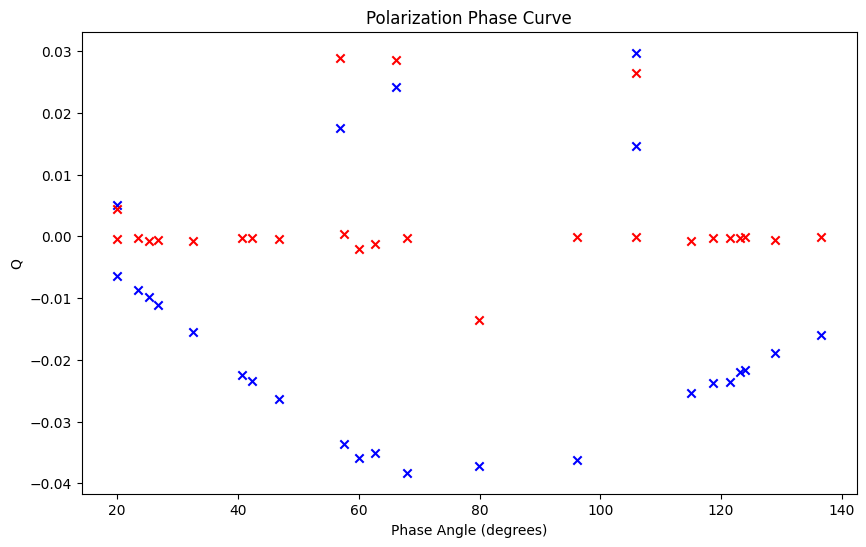

In [61]:
#For sanity we plot; looks pretty much exaclty the same whether or not we do the whole image os masked image

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, norm_Q, color='b', marker='x')
plt.scatter(phase_angles, norm_U, color='r', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')
plt.show()

With the specific values of Q and U depending on the choice of the reference system. We introduce a new reference frame where Q_cam and U_cam are the stokes parameters before projection, such that we can find the new components after rotation as:

\begin{equation}

\begin{bmatrix} 
I \\ Q \\ U 
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(2\theta') & \sin(2\theta') \\
0 & -\sin(2\theta') & \cos(2\theta')
\end{bmatrix}

\begin{bmatrix} 
I_{\text{cam}} \\ Q_{\text{cam}} \\ U_{\text{cam}} 
\end{bmatrix}
\end{equation}

Which gives us the following equations, wher theta is the polarization(or projection) angle:

\begin{equation}
Q = Q_{cam}cos(2\theta') + U_{cam}sin(2\theta')
\end{equation}

\begin{equation}
U = -Q_{cam}sin(2\theta') + U_{cam}cos(2\theta')
\end{equation}

To ensure that this works, lets consider again the case where U = 0, this would mean that the electric field vector of polarized lights coming from Titan hs to be either parallel or perpendicular to the camera's Y-axis; this is done by setting the scattering plane to be perpendicular to the camera y-axis. If U = 0, then we can calculate the projection angle,

\begin{equation}
0 = -Q_{cam}sin(2\theta') + U_{cam}cos(2\theta')
\end{equation}

\begin{equation}
tan(2\theta') = \frac{U_{cam}}{Q_{cam}}
\end{equation}

\begin{equation}
\theta' = \frac{1}{2} arctan\frac{U_{cam}}{Q_{cam}}
\end{equation}

We've already built the functions to calculate Q_cam and U_cam in the original reference frame above, so now we just need to setup calculation for Q and $\theta$'.

In [62]:
def rotate_Q(Q_cam, U_cam):
    x = U_cam / Q_cam
    new_theta =  0.5 * np.arctan(x)
    #new_theta =  0.5 * np.arctan2(U_cam, Q_cam)
    return Q_cam * np.cos(2 * new_theta) + U_cam * np.sin(2 * new_theta)

And again, we use the same loop just adding a line to calculate the rotated Q assuming U = 0.

In [63]:
rotate_Qs = []
dlop_test = []

for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        IF_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        IF_vic = vicar.VicarImage(IF_image_path, strict=False)
        read_IF_image = IF_vic.data_2d

        thet_image_path = pol_image_path.replace('_Pol.vic', '_Theta.vic')
        thet_vic = vicar.VicarImage(thet_image_path, strict=False)
        read_thet_image = thet_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

                n_q = norm_stokes_Q(read_pol_image, read_IF_image, read_thet_image, center, eff_radius, pixel_scale)
                n_u = norm_stokes_U(read_pol_image, read_IF_image, read_thet_image, center, eff_radius, pixel_scale)
                r_q = rotate_Q(n_q, n_u)
                thet_test = 0.5 * np.arctan2(n_u, n_q)
                polar_test = np.sqrt(n_q**2 + n_u**2)

                #Creating array to plot
                rotate_Qs.append(r_q)
                dlop_test.append(polar_test)

                #For manual inspection
                print(f'{filename}: {r_q}, {thet_test}, {n_u}, {polar_test}')

N1486913_Pol.vic: -0.008743722190654326, -1.553178399649616, -0.00030802877218748346, 0.008743722190654326
N1494007_Pol.vic: -0.016012043754893013, -1.5668993940638678, -0.00012479445136319076, 0.016012043754893013
N1499415_Pol.vic: -0.03595769827331035, -1.5427264795721018, -0.002017594007385019, 0.03595769827331034
N1515805_Pol.vic: -0.02246592545296594, -1.5647332207766778, -0.00027241989919142253, 0.022465925452965937
N1521214_Pol.vic: -0.03827785375155242, -1.567863579889131, -0.0002245172269108223, 0.03827785375155242
N1526619_Pol.vic: -0.036201073875621714, -1.568433124025524, -0.00017110031904019038, 0.036201073875621714
N1530756_Pol.vic: -0.02360553022095689, -1.5644739816821933, -0.00029847666328648454, 0.023605530220956888
N1534852_Pol.vic: -0.02188621619779881, -1.5642636818190478, -0.0002859416252826722, 0.021886216197798805
N1536147_Pol.vic: -0.018886649214226895, -1.5555316206999734, -0.0005765087336591543, 0.018886649214226895
N1537508_Pol.vic: -0.021569786425609708, -1

Thoughts: After this test, I see that polar test, where I try to calculate the degree of linear polarization and r_q, which is the rotated frame are the exact same. I supsect that the reason is because the rotated angle is approximatly zero, since Q is so small; this means that theta prime is also going to be really small(as seen) or approximately zero. Which means that the new Q will be approximately still just Q_cam since U_cam is multiplied by 0. BUT, then why would polar test which calculates Q_cam; and DLOP is really small and approximately Q_cam because U_cam is even closr to zero than theta prime.

Thoughts: SO the root culprite in the small calculations HAS to be this calculation for Q_cam and U_cam. The issue isn't any of the rotation or tensor logic, its upstream.

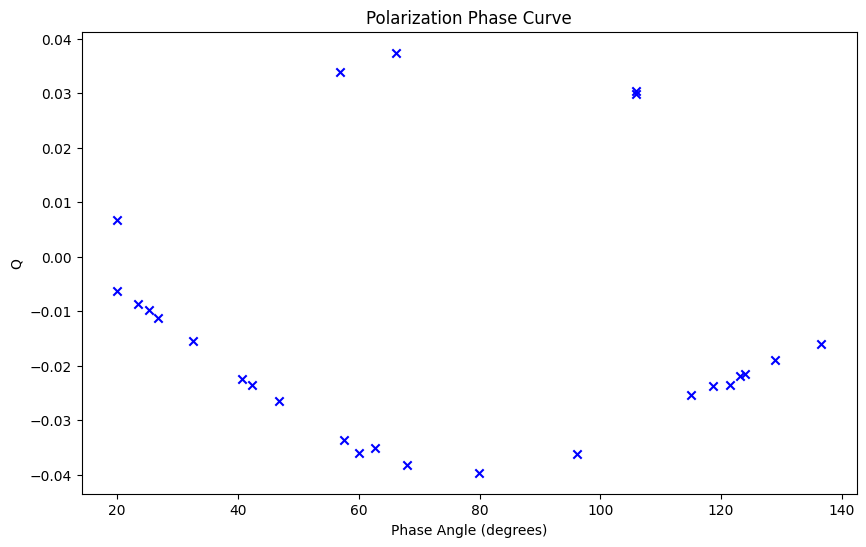

In [64]:
#For sanity we plot; looks pretty much exaclty the same whether or not we do the whole image os masked image

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, rotate_Qs, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')
plt.show()

This was expected, but we will progress with an alternative method using tensors. THIS METHOD is all derived from the work of N. Ilic. While the code is original, the math and explanations behind the theory belong to N. Ilic, I only take credit for writing out the code, nothing else.

The goal is to determine the direction of symmetry of brightness and to assume that it is perpendicular to the scattering plane, which will be done by solving the Eigenproblem for the tensor of brightness inertia. The elements of the tensor are the moments of inertia and they give the distribution of bright pixels relative to the x- and the y-axis that are going through the center of brightness of the disk. The tensor has to be determined for each brightness image and as a result it gives the direction of symmetry of brightness for that image.

The tensor of interia has the form:

\begin{equation}

M
=
\begin{bmatrix}
I_{xx} & -I_{xy} \\
-I_{xy} & I_{yy}
\end{bmatrix}

\end{equation}

With the elements being the moments of intertia along the x and y axis:

\begin{equation}
I_{xx} = \sum_{ij} (y_{ij} - y_{cm})^2 I_{ij}
\end{equation}

\begin{equation}
I_{yy} = \sum_{ij} (x_{ij} - x_{cm})^2 I_{ij}
\end{equation}

\begin{equation}
I_{xy} = \sum_{ij} (y_{ij} - y_{cm})(x_{ij} - x_{cm}) I_{ij}
\end{equation}

In [32]:
#Creating a 2x2 intertia tensor for brightness centered at the center of the disk of Titan
#Center given by image_center_tensor
def tensor_calc(image, center):

    y_index, x_index = np.indices(image.shape)
    dx = x_index - center[0]
    dy = y_index - center[1]

    Ixx = np.sum((dy**2)*image)
    Iyy = np.sum((dx**2)*image)
    Ixy = np.sum((dy * dx)*image)

    M = np.array([[Ixx, -Ixy],
                  [-Ixy, Iyy]])
    
    return M

To calculate the Eigenvectors of the matrix defined above, we can just use numpy. One of the two resulting Eigenvectors is parallel to the direction of symmetry, the other is perpendicular. The tensor angle can be calculated after wer figure out which of the two vectors is the parallel one, which we will call out principle vector:

\begin{equation}
E = (E_x, E_y)
\end{equation}

In [33]:
def direction_calc(M):
    eigenval, eigenvec = np.linalg.eigh(M)
    princ_val = np.argmax(eigenval)
    princ_vec = eigenvec[:, princ_val]
    return princ_vec
#This is the direction of the eigenvector in the Y-axis

If:
\begin{equation}
e_y = (0, 1)
\end{equation}

Then we can caclualte the angle as:

\begin{equation}
\theta' = arccos \frac{e_y * E}{|e_y| * |E|} = arccos \frac{E_y}{\sqrt{E_x^2 + E_y^2}}
\end{equation}

In [34]:
def tensor_angle_calc(princ_vec):
    Ex, Ey = princ_vec
    denom = np.sqrt(Ex**2 + Ey**2)
    return np.arccos( Ey / denom)

So U can be expressed in terms of this new angle and the original Q_cam:

\begin{equation}
U_{cam} = Q_{cam} tan{2\theta'}
\end{equation}

Which gives:

\begin{equation}
Q = \frac{Q_{cam}}{cos(2\theta')}
\end{equation}

In [35]:
def tensor_Q_calc(Q_cam, tensor_angle):
    return Q_cam/np.cos(2* tensor_angle)

In [65]:
tensor_Qs = []

for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        IF_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        IF_vic = vicar.VicarImage(IF_image_path, strict=False)
        read_IF_image = IF_vic.data_2d

        thet_image_path = pol_image_path.replace('_Pol.vic', '_Theta.vic')
        thet_vic = vicar.VicarImage(thet_image_path, strict=False)
        read_thet_image = thet_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

                n_q = norm_stokes_Q(read_pol_image, read_IF_image, read_thet_image, center, eff_radius, pixel_scale)
                tensor = tensor_calc(read_IF_image, center)
                direction = direction_calc(tensor)
                tensor_angle = tensor_angle_calc(direction)
                tensor_q = tensor_Q_calc(n_q, tensor_angle)
                
                #Creating array to plot
                tensor_Qs.append(tensor_q)

                #For manual inspection
                print(f'{filename}: {tensor_q}, {tensor_angle}')

N1486913_Pol.vic: 0.009451531960585485, 1.7662845286237396
N1494007_Pol.vic: 0.01604457608561968, 1.602879331433434
N1499415_Pol.vic: 0.2361211904999661, 2.2798759824431394
N1515805_Pol.vic: 0.047286898034425345, 2.108676460342509
N1521214_Pol.vic: 0.04273055185741825, 1.8011024719751885
N1526619_Pol.vic: 0.03672813136720302, 1.655636633907451
N1530756_Pol.vic: 0.02386358487967433, 1.4969293715812977
N1534852_Pol.vic: 0.022309675765362153, 1.4730067584685647
N1536147_Pol.vic: 0.019029087832070298, 1.6338770622884211
N1537508_Pol.vic: 0.021887750832896943, 1.6561646427281438
N1547135_Pol.vic: 0.023896511764345117, 1.621916668557492
N1549547_Pol.vic: 0.025385168547931204, 1.5606931411626057
N1551056_Pol.vic: 0.0351242549953088, 1.5525102605113252
N1553821_Pol.vic: 0.02639289174874975, 1.5760641189856328
N1556523_Pol.vic: 0.015506942532986009, 1.5198249631066225
N1557905_Pol.vic: 0.010943015295571325, 1.3375357556556091
N1559282_Pol.vic: 0.006382437436706838, 1.5122168253106343
N1567440_P

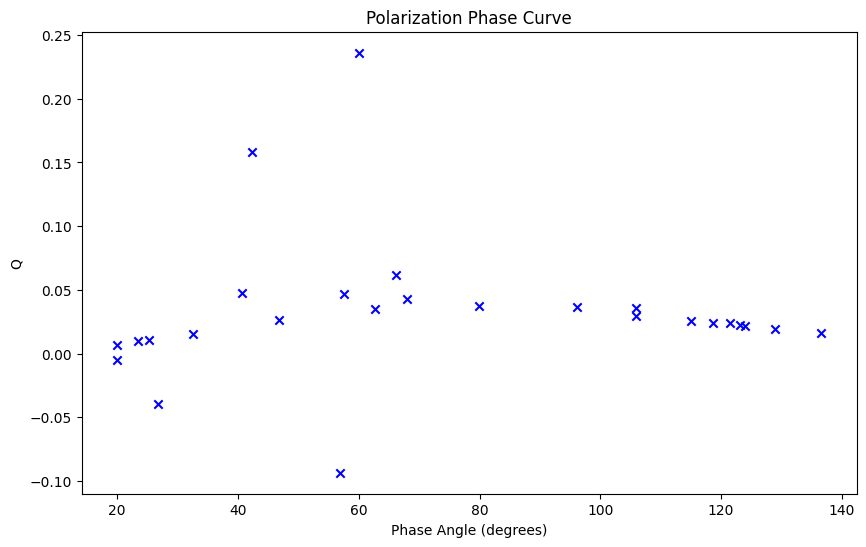

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, tensor_Qs, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')
plt.show()

So using this method, its producing almost exaclty the same thing as the rotated frame. But, of particular interest is that the angles of polarization are extremely small, suhc that it is basically 0 or every image, which means that it is not really being rotated, and perhaps assuming U= 0 is already a decent assumption. 